In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
from sklearn.metrics import ConfusionMatrixDisplay

def indeces_func(group_set, label):
    indeces = []
    for ind in group_set.index:
        if group_set.loc[ind][0] == label:
            indeces.append(ind)
    return indeces


def mu_inv_cov_mult(mu, cov):
    return mu.T.dot(np.linalg.pinv(cov)).dot(mu)


def compute_sigma_hat(feature_set, target_var, class_label):
    X = feature_set[feature_set == class_label].drop(target_var, axis=1)
    X_demeaned = X - X.mean()
    X_var = (np.sum(np.square(X - X_demeaned))) / n
    
    return X_var

def split_sample(sample, train_size, permute):
    sample_copy = sample.copy()
    size = int(train_size * len(sample_copy))
    
    if permute == True:
        np.random.seed(0)
        shuffled_indeces = np.arange(len(sample))
        np.random.shuffle(shuffled_indeces)
        indeces_train = shuffled_indeces[:size]
        indeces_test = shuffled_indeces[size:]

    elif permute == False:
        indeces_train = np.arange(len(sample))[:size]
        indeces_test = np.arange(len(sample))[size:]

    train_sample = sample_copy.iloc[indeces_train]
    test_sample = sample_copy.iloc[indeces_test]
    return train_sample, test_sample


def x_y_splitting(data, regressors_ind, explained_var_ind):
    df = pd.DataFrame(data[regressors_ind])
    n = df.shape[0]
    X = df.copy()
    Y = pd.DataFrame(data[explained_var_ind])
    return X, Y


def covariance(feature_set, feature_1, feature_2):
    var_1 = feature_set.columns[feature_1]
    var_2 = feature_set.columns[feature_2]
    X_1 = feature_set[var_1].copy()
    X_2 = feature_set[var_2].copy()
    
    X_1_demeaned = X_1 - X_1.mean()
    X_2_demeaned = X_2 - X_2.mean()
    
    covar = (np.sum(X_1_demeaned * X_2_demeaned)) / len(X_1)
    return covar
    

def classify_lda(feature_set, mu_params, cov_params, pi_params, class_labels, threshold_value, compute_crit_value=False):
    """Classify features_set:

    FOR TASK 1: for the binary classification and one feature you can use explicit expression for
    critical values as decision boundaries; however, you will still need to generalize
    the expressions in slide 49 in Chapter 4 for the case of threshold C different from 1/2 (see slide 51).
    FOR OTHER TASKS: multiple classes and/or multiple features you will have
    to compute the Gaussian discriminant functions delta_r for r = {1,...,k}

    Args:
        feature_set: variable where each row corresponds to an observation or replicate
        to be classified, and each column corresponds to a feature or input variable.

        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components.
        Otherwise:
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k}) contains means for all d features.

        cov_params: contains the learnt (estimated) covariance shared by all the
        the classes/groups (in the 1 feauture case cov_params should contain
        just the variance value).
        Otherwise: covariance matrix in dimension d.

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification case pi_params should be a vector
        with two nonnegative values with sum = 1.

        class_labels: labels assigned to feature_set; group_set will be labeled
        with classLabels.

        threshold_value C: can be specified for the case of binary classification.
        The decision boundary is given by
        \delta_1(x) - \delta_0(x) = log(C/(1-C)) (*) (see slide 51 in Chapter 4)
        and the critical value x_crit is computed as
        as the solution of this equation (*).
        The default value is C=1/2 which renders the decision boundary
        \delta_1(x) - \delta_0(x) = 0
        (hint: be attentive with the log transform,
        log(C/(1-C)) = 0 for the thresshold C = 1/2).

        compute_crit_value: valid only for binary classification and just 1
        feature, is set to 0 by default.

    Returns:
        group_set: contains labels for each of the input feature_set

        x_crit_value: if compute_crit_value is different from 0 contains the
        x_crit_value for a given threshold_value C
    """

    # Determine if it is a binary classification task. If yes, use critical
    # value.
    class_labels_number = len(class_labels)
    num_obs, num_features = feature_set.shape
    x_crit_value = None

    if class_labels_number == 2:
        # in the following code allow for the different thresholds to be set

        # ====================== YOUR CODE STARTS HERE ======================
        X_copy = feature_set.copy()
        if num_features > 1:
            _ = X_copy.dot(np.linalg.pinv(cov_params)).dot(mu_params[1] - mu_params[0])
            __ = np.log(pi_params[1] / pi_params[0])
            ___ = mu_inv_cov_mult(mu_params[1], cov_params) - mu_inv_cov_mult(mu_params[0], cov_params)
        else:
            inv_cov = 1 / cov_params
            _ = X_copy.dot(mu_params[1] - mu_params[0]) * inv_cov
            __ = np.log(pi_params[1] / pi_params[0])
            ___ = mu_params[1].T.dot(mu_params[1]) * inv_cov - mu_params[0].T.dot(mu_params[0]) * inv_cov
        X_copy = _ + __ - 0.5 * ___
        log_thresh = np.log(threshold_value / (1 - threshold_value))
        Y_array = np.where(np.array(X_copy) > log_thresh, class_labels[1], class_labels[0])
        group_set = pd.DataFrame(data=Y_array, index=feature_set.index)
        # ====================== YOUR CODE ENDS HERE ========================

        if compute_crit_value and num_features == 1:
            # ====================== YOUR CODE STARTS HERE ======================
            _ = (mu_params[1] ** 2 - mu_params[0] ** 2) / (2 * cov_params ** 2)
            __ = np.log((1 - pi_params[1]) / pi_params[1])
            if threshold_value != 0.5:
                __ += np.log(threshold_value / (1 - threshold_value))
            x_crit_value = (cov_params ** 2) * (_ + __) / (mu_params[1] - mu_params[0])
            # ====================== YOUR CODE ENDS HERE ========================
    else:
        # ====================== YOUR CODE STARTS HERE ======================
        deltas = []
        for r in range(class_labels_number):
            _r = feature_set.dot((np.linalg.pinv(cov_params)).dot(mu_params[r]))
            __r = mu_inv_cov_mult(mu_params[r], cov_params)
            deltas.append(np.array(_r - 0.5 * __r + np.log(pi_params[r])))
        deltas = np.array(deltas).T
        data = pd.DataFrame(data=deltas, index=feature_set.index)
        group_set = []
        for ind in data.index:
            group_set.append(class_labels[data.loc[ind].idxmax()])
        group_set = pd.DataFrame(data=group_set, index=feature_set.index)
        # ====================== YOUR CODE ENDS HERE ========================
    return group_set, x_crit_value


def classify_naive_bayes_gauss(feature_set, mu_params, cov_params, pi_params, class_labels, threshold_value=0.5):
    """
    Args:
        feature_set: variable where each row corresponds to an observation or replicate
        to be classified, and each column corresponds to a feature or input variable.

        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components.
        Otherwise:
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k}) contains means for all d features.

        cov_params: contains the learnt (estimated) variances of features
        with the classes/groups (in the 1 feature
        case cov_params should contain just the variance value). Otherwise -
        d x k matrix where each j-th column
        (with j = {1,...,k})
        contains variances for all d features

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification case pi_params should be a vector
        with two nonnegative values with sum = 1.

        class_labels: labels assigned to features_set; group_set will be labeled
        with class_labels.

        threshold_value C: can be specified for the case of binary classification.
        The decision boundary is given by
        \delta_1(x) - \delta_0(x) = log(C/(1-C)) (*) (see slide 51 in Chapter 4)
        and the critical value x_crit is computed as
        as the solution of this equation (*).
        The default value is C=1/2 which renders the decision boundary
        \delta_1(x) - \delta_0(x) = 0
        (hint: be attentive with the log transform,
        log(C/(1-C)) = 0 for the threshold C = 1/2).

    Returns:
        group_set
    """

    n = feature_set.shape[0]
    d = feature_set.shape[1]
    Y_hat = np.zeros(n)
    
    class_labels_number = len(class_labels)

    if class_labels_number == 2:
        # in the following code allow for the different thresholds to be set
        # ====================== YOUR CODE STARTS HERE ======================
        for i in range(n):
            delta = np.ones(2) 
            for class_index in range(class_labels_number):
                for j in range(d):
                    delta[class_index] *= ( (1 / (math.sqrt(2 * math.pi * cov_params[class_index, j]))) * math.exp(- ((feature_set.iloc[i, j] - mu_params[class_index, j]) ** 2) / (2 * (cov_params[class_index, j])) ))
                delta[class_index] *= pi_params[class_index]
            predict_class_index = int((delta[1] / delta[0]) > (threshold_value / (1 - threshold_value)))
            Y_hat[i] = class_labels[predict_class_index]
        # ====================== YOUR CODE ENDS HERE ========================
    else:
        # ====================== YOUR CODE STARTS HERE ======================
        

        for i in range(n):
            PofX = np.ones(class_labels_number) #вектор, в котором хранятся вер-ти попадания строки в каждый из class_labels
            for class_index in range(class_labels_number):
                for j in range(d):
                    PofX[class_index] *= ( (1 / (math.sqrt(2 * math.pi * cov_params[class_index, j]))) * math.exp(- ((feature_set.iloc[i, j] - mu_params[class_index, j]) ** 2) / (2 * (cov_params[class_index, j])) ))
                PofX[class_index] *= pi_params[class_index]
            Y_hat[i] = class_labels[np.argmax(PofX)]
        # ====================== YOUR CODE ENDS HERE ========================
    return Y_hat


def classify_qda(feature_set, mu_params, cov_params, pi_params, class_labels, threshold_value):
    """
    Classify feature_set according to QDA.

    Args:
        feature_set: variable where each row corresponds to an observation or replicate
        to be classified, and each column corresponds to a feature or input variable.

        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components.
        Otherwise:
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k}) contains means for all d features.

        cov_params: contains the learnt (estimated) covariances for each of
        the k classes/groups (in the 1 feature
        case cov_params should contain just the k variance values). Otherwise -
        covariance matrices in dimension d. You can think of creating a cell
        array or a three-dimensional array

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification case pi_params should be a vector
        with two nonnegative values with sum = 1.

        class_labels: labels assigned to feature_set; group_set will be labeled
        with class_labels.

        threshold_value C: can be specified for the case of binary classification.
        The decision boundary is given by
        \delta_1(x) - \delta_0(x) = log(C/(1-C)) (*) (see slide 51 in Chapter 4)
        and the critical value x_crit is computed as
        as the solution of this equation (*).
        The default value is C=1/2 which renders the decision boundary
        \delta_1(x) - \delta_0(x) = 0
        (hint: be attentive with the log transform,
        log(C/(1-C)) = 0 for the thresshold C = 1/2).

    Returns:
        group_set
    """


    class_labels_number = len(class_labels)
    num_obs, num_features = feature_set.shape

    #delta_vals = np.zeros((num_obs, class_labels_number))
    deltas = []
    
    

    # compute the delta_vals
    # ====================== YOUR CODE STARTS HERE ======================
    for r in range(class_labels_number):
        if num_features > 1:
            _r = -0.5 * np.log(np.linalg.det(cov_params[r]))
        else:
            _r = -0.5 * np.log(cov_params[r])
        __r = []
        if num_features > 1:
            for i in range(len(feature_set)):
                __r.append(np.array((feature_set.iloc[i:i + 1, :] - mu_params[r].T) \
                           .dot((np.linalg.pinv(cov_params[r])) \
                                .dot((feature_set.iloc[i:i + 1, :] - mu_params[r].T).T)).iloc[0,:])[0])
        else:
            inv_cov_param_r = 1 / cov_params[r]
            for i in range(len(feature_set)):
                __r.append(np.array(((feature_set.iloc[i:i + 1, :] - mu_params[r].T) \
                           .dot((feature_set.iloc[i:i + 1, :] - mu_params[r].T).T) * inv_cov_param_r).iloc[0,:])[0])
                            
                                
        __r = np.array(__r)
        deltas.append(np.array(_r - 0.5 * __r + np.log(pi_params[r])))
    # ====================== YOUR CODE ENDS HERE ========================

    # if one has only two classes you can chose a different threshold value
    # (other than 1)

    if class_labels_number == 2 and threshold_value != 0.5:
        # ====================== YOUR CODE STARTS HERE ======================
        X_copy = deltas[1] - deltas[0]
        log_thresh = np.log(threshold_value / (1 - threshold_value))
        Y_array = np.where(np.array(X_copy) > log_thresh, 1, 0)
        group_set = pd.DataFrame(data=Y_array, index=feature_set.index)
        # ====================== YOUR CODE ENDS HERE ========================
    else:
        # ====================== YOUR CODE STARTS HERE ======================
        deltas = np.array(deltas).T
        data = pd.DataFrame(data=deltas, index=feature_set.index)
        group_set = []
        for ind in data.index:
            group_set.append(class_labels[data.loc[ind].idxmax()])
        group_set = pd.DataFrame(data=group_set, index=feature_set.index)
        # ====================== YOUR CODE ENDS HERE ========================
    return group_set


def compute_loss(Y, Y_pred, type_of_loss):
    """
    Compute loss

    Returns:
        loss
        type_I_error
        type_II_error
    """

    loss = 0

    # relevant only for binary classification. In this case the labels are
    # assumed to be 1 and 0.
    type_I_error = 0
    type_II_error = 0

    if type_of_loss == 'mse':
        # ====================== YOUR CODE STARTS HERE ====================
        loss += np.square(Y - Y_pred).mean()
        # ====================== YOUR CODE ENDS HERE ======================
    elif type_of_loss == '0-1':
        if set(Y['Class']) == {0, 1}:
            # ====================== YOUR CODE STARTS HERE ====================
            for j in Y.index:
                if Y.loc[j][0] != Y_pred.loc[j][0]:
                    if Y.loc[j][0] == 1 and Y_pred.loc[j][0] == 0:
                        type_II_error += 1
                    elif Y.loc[j][0] == 0 and Y_pred.loc[j][0] == 1:
                        type_I_error += 1
            loss += type_I_error + type_II_error
            # ====================== YOUR CODE ENDS HERE ======================
        else:
            # ====================== YOUR CODE STARTS HERE ====================
            for i in Y.index:
                if Y.loc[i][0] != Y_pred.loc[i][0]:
                    loss += 1
            # ====================== YOUR CODE ENDS HERE ======================
    else:
        raise ValueError('The type of loss is not known')
    
    return loss, type_I_error, type_II_error


def fit_lda(feature_set, group_set, class_labels):
    """
    Args:
        feature_set: where each row corresponds to an observation or replicate,
        and each column corresponds to a feature or variable

        group_set: variable with each row representing a class label.
        Each element of group_set specifies the group of the corresponding row of
        feature_set

        class_labels: provide the labels according to which we order the output
        parameters. They determine in which order the parameters are constructed

    Returns:
        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components. Otherwise -
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k}) contains means for all d features

        cov_params: contains the learnt (estimated) covariance shared by all the
        the classes/groups (in the 1 feature case cov_params should contain just
        the variance value). Otherwise - covariance matrix in dimension d

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification
        case pi_params should be a vector with two nonnegative values with sum = 1
    """

    #  Instructions
    #  ------------
    #  Note that these are supervised learning algorithms, thus:
    #   - pi_params are sample-based estimates of prior probabilities of each class;
    #   - mu_params are means of features within teh classes;
    #   - cov_params is the pooled mean of the var/covariance matrix shared by
    #     all classes (see slide 43 in Chapter 4);

    # ====================== YOUR CODE STARTS HERE ======================
    class_labels_number = len(class_labels)
    d = len(feature_set.columns)
    n = len(group_set)
    pi_params = []
    mu_params = []
    indeces = []
    for r in range(class_labels_number):
        indeces = indeces_func(group_set, class_labels[r])
        pi_params.append(len(indeces) / n)
        mu_params.append(feature_set.loc[indeces, :].mean())
    
    if d > 1:
        cov_params = np.zeros((d, d))
        for feature_1 in range(d):
            for feature_2 in range(d):
                cov_params[feature_1][feature_2] = covariance(feature_set, feature_1, feature_2)
    elif d == 1:
        cov_params = covariance(feature_set, 0, 0)
    
    pi_params = np.array(pi_params)
    mu_params = np.array(mu_params)
    
    return mu_params, cov_params, pi_params
    # ====================== YOUR CODE ENDS HERE ========================


def fit_naive_bayes_gauss(feature_set, group_set, class_labels):
    """
    Args:
        feature_set: where each row corresponds to an observation or replicate,
        and each column corresponds to a feature or variable

        group_set: variable with each row representing a class label.
        Each element of group_set specifies the group of the corresponding row of
        feature_set

        class_labels: provide the labels according to which we order the output
        parameters. They determine in which order the parameters are constructed

    Returns:
        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components. Otherwise -
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k})
        contains means for all d features

        cov_params: contains the learnt (estimated) variances of feautures
        with the classes/groups (in the 1 feature
        case cov_params should contain just the variance value). Otherwise -
        d x k matrix where each j-th column
        (with j = {1,...,k})
        contains variances for all d features

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification
        case pi_params should be a vector with two nonnegative values with sum = 1
    """

    #  Instructions
    #  ------------
    #  Note that these are supervised learning algorithms, thus:
    #   - pi_params are sample-based estimates of prior probabilities of each class;
    #   - mu_params are means of features within classes;
    #   - cov_params are only the variances of the var/covariance matrices of
    #     each feauture within each class. Think carefully on how to fill the
    #     'cov_params' and also remember the conditional independence
    #     assumptions adopted for Naive Bayes
    #
    
    # ====================== YOUR CODE STARTS HERE ======================
    n = feature_set.shape[0]
    d = feature_set.shape[1]
    
    mu_params = np.zeros((len(class_labels), d))
    cov_params = np.zeros((len(class_labels), d))
    for k in range(len(class_labels)):
        feature_set_copy = feature_set.copy()
        X = feature_set_copy[group_set.iloc[:, 0] == class_labels[k]]
        X_mean = [X.iloc[:, i].mean() for i in range(d)]
        mu_params[k] = X_mean

        X_var = [X.iloc[:, i].var() for i in range(d)]
        cov_params[k] = X_var
        
    pi_params = np.zeros(len(class_labels))
    for i in range(len(class_labels)):
        pi_params[i] = group_set[group_set == class_labels[i]].count() / n
        
    return mu_params, cov_params, pi_params
    # ====================== YOUR CODE ENDS HERE ========================


def fit_qda(feature_set, group_set, class_labels):
    """
    Args:
        feature_set: where each row corresponds to an observation or replicate,
        and each column corresponds to a feature or variable

        group_set: variable with each row representing a class label.
        Each element of group_set specifies the group of the corresponding row of
        feature_set

        class_labels: provide the labels according to which we order the output
        parameters. They determine in which order the parameters are constructed

    Returns:
        mu_params: contains the learnt (estimated) mean values for the given
        feature within the classes/groups. In the case of binary classification and 1 feature
        case mu_params should be a vector with two real components. Otherwise -
        you can organize them for example as d x k matrix where each j-th column
        (with j = {1,...,k})
        contains means for all d features

        cov_params: contains the learnt (estimated) covariances for each of
        the k classes/groups (in the 1 feature
        case cov_params should contain just the k variance values). Otherwise -
        covariance matrices in dimension m. You can think of creating a cell
        array or a three-dimensional array

        pi_params: contains the learnt (estimated) P(Y=label) prior probabilities
        for each i-th class (with i = {1,...,k}).
        In the case of binary classification
        case pi_params should be a vector with two nonnegative values with sum = 1
    """ 

    #  Instructions
    #  ------------
    # See slide 43 in Chapter 4
    #  Note that these are supervised learning algorithms, thus:
    #   - pi_params are sample-based estimates of prior probabilities of each class;
    #   - mu_params are means of features within the classes;
    #   - cov_params are the var/covariance matrices of each class. Think
    #     carefully on how to fill the 'cov_params'!
    #

    # ====================== YOUR CODE STARTS HERE ======================
    class_labels_number = len(class_labels)
    d = len(feature_set.columns)
    n = len(group_set)
    pi_params = []
    mu_params = []
    indeces = []
    cov_params = []
    for r in range(class_labels_number):
        indeces_r = indeces_func(group_set, class_labels[r])
        indeces.append(indeces_r)
        pi_params.append(len(indeces_r) / n)
        mu_params.append(feature_set.loc[indeces_r, :].mean())
    
    if d > 1:
        for r in range(class_labels_number):
            cov_params_r = np.zeros((d, d))
            for feature_1 in range(d):
                for feature_2 in range(d):
                    cov_params_r[feature_1][feature_2] = covariance(feature_set.loc[indeces[r], :], feature_1, feature_2)
            cov_params.append(cov_params_r)
    elif d == 1:
        for r in range(class_labels_number):
            cov_params_r = covariance(feature_set.loc[indeces[r], :], 0, 0)
            cov_params.append(cov_params_r)
    
    pi_params = np.array(pi_params)
    mu_params = np.array(mu_params)
    
    return mu_params, cov_params, pi_params
    # ====================== YOUR CODE ENDS HERE ========================


#  Generative classifiers for binary and multiclass classification with one
#  and multiple features
#
#  Instructions
#  ------------
#
#  This file contains code that helps you to get started on the
#  generative classification exercise.
#
#  You will need to complete the following functions in this
#  exericse:
#
#     fit_lda
#     classify_lda
#     fit_qda
#     classify_qda
#     compute_loss
#     fit_naive_bayes_gauss
#     classify_naive_bayes_gauss
#
#  Data description (see http://archive.ics.uci.edu/ml/datasets/Wine)
#  ------------------------------------------------------------------
#
#  > These data are the results of a chemical analysis of
#    wines grown in the same region in Italy but derived from three
#    different cultivars.
#    The analysis determined the quantities of 13 constituents
#    found in each of the three types of wines.
#
#    Number of Instances
#
#         class 1 -> 59
# 	      class 2 -> 71
# 	      class 3 -> 48
#
#    Number of Attributes
#
#         13
#
## Load Data ======================================================


#  Load the 'wine.csv' dataset and determine how many classes there are in
#  the dataset. Create separate variables containing the class labels and all the
#  available features. Create a variable containing the names of the features,
#  for that look at the description of the data following the link provided
#  above. Determine how many representatives of each class
#  there are in the dataset



## Part I: Binary Classification with One Feature ========================

# Select only classes 1 and 3 for this part and feature 'Proanthocyanins'.
# In this binary classification exercise assign label 0 to Class 1 and
# label 1 to Class 3.


###########################################################################
# Task 0: Plot the data by creating two <count> density-normalized histograms in
# two different colors
# of your choice; for that use the specific normalization and bin width 0.3.
# Add the grid.
# Add descriptive legend and title.
###########################################################################


###########################################################################
# Task 1 : Construct LDA classifier. For that fill in the function fit_lda
# and classify_lda. Both functions should be constructed in order to
# work with multiple classes and multiple feautures if needed. We start
# here however with only binary classification which for the case of univariate feautures
# admits the explicit critical decision boundary value x_crit (see Slide 49 in Chapter 4),
# since we assume that the threshold is C = 1/2 (see our discussions in Tutorial 3)
##########################################################################


###########################################################################
# Task 2 : Compute the empirical value of the error using the 0-1 loss.
# For that add typeOfLoss '0-1' option to the function compute_loss from the
# previous assignment. Additionally, this function needs to output the Type I and Type II
# errors (false positive and false negative) which will be used only in the case of
# binary classification
##########################################################################


###########################################################################
# Task 3 : Plot the resulting classification.
# Create two histograms in two different colors of your choice: for these,
# use normalization, and bin width 0.3.
# Superimpose the two normal distributions and the Gaussian mixture distribution that you
# obtain with the parameters computed in the 'fit_lda' function.
# Add the grid.
# Add descriptive legend and title.
# Plot the decision boundary (critical value x_crit for the given threshold C of interest,
# which is set by default to 1/2)
##########################################################################


###########################################################################
# Task 4 : Construct QDA classifier. For that fill in the function fit_qda
# and classify_qda. Both functions should be constructed in order to
# work with multiple classes and multiple features if needed. We start
# here however with only two-classes classification first.
##########################################################################


###########################################################################
# Task 5 : Compute the empirical value of the error using the 0-1 loss.
# using the function compute_loss together with the Type I and Type II
# errors
##########################################################################


###########################################################################
# Task 6 : Plot the resulting classification.
# Create two histograms in two different colors of your choice: for these,
# use normalization and bin width 0.3.
# Superimpose the two normal distributions and the mixed distribution that you
# obtain as a result from the 'fit_lda' function.
# Add the grid.
# Add descriptive legend and title.
##########################################################################


###########################################################################
# Task 7 : Construct the Gaussian Naive Bayes classifier. For that fill in the
# function fit_naive_bayes_gauss and classify_naive_bayes_gauss.
# Both functions should be constructed in order to work with multiple
# classes and multiple features if needed. However, we start with only
# two-classes classification.
#########################################################################


###########################################################################
# Task 8 : Compute the empirical value of the error using the 0-1 loss.
# using the function compute_loss together with the Type I and Type II
# errors
##########################################################################


###########################################################################
# Task 9 : Plot the resulting classification.
# Create two histograms in two different colors  of your choice: for these,
# use normalization and bin width 0.3.
# Superimpose the two normal distributions and the mixed distribution that you
# obtain as a result from the 'fit_naive_bayes_gauss' function.
# Add the grid.
# Add descriptive legend and title.
##########################################################################


## Part II: Binary Classification with Two Features ======================

# Select only classes 1 and 3 for this part and features:
#
#   - 'Proanthocyanins'
#   - 'Alcalinity of ash'
#
# In this binary classification exercise assign label 0 to Class 1 and
# label 1 to Class 3.


###########################################################################
# Task 10 : Generalize LDA, QDA, GNB to the case of two features. Report
# their training/LOOCV errors for the stadard threshold C=1/2, plot.
##########################################################################


###########################################################################
# Plot the resulting classification.
# Add the grid.
# Add descriptive legend and title.
# Mark misclassified observations.
##########################################################################

# Compare all the classifiers via plotting their ROC curves and computing the area under ROC (AUC).
# Draw conclusions.


## Part III: 3-Classes Classification with Many Features ====================

# Select only classes 1, 2, and 3 for this part and features:
#
#   - 'Alcohol'
#   - 'Flavanoids'
#   - 'Proanthocyanins'
#   - 'Color intensity'
#


###########################################################################
# Task 11 : Construct QDA classifier for the following:
#
#   - 'Alcohol'
#   - 'Alcohol' + 'Proanthocyanins'
#   - All features listed above
#
##########################################################################


###########################################################################
# Compute the empirical value of the errors using the 0-1 loss.
##########################################################################

In [3]:
def confusion(group_set, prediction):
    loss, type_I_error, type_II_error = compute_loss(group_set, prediction,'0-1')
    positive_num = group_set[group_set['Class'] == 1].count()[0]
    negative_num = group_set[group_set['Class'] == 0].count()[0]
    FPs = type_I_error
    FNs = type_II_error
    TNs = negative_num - FPs
    TPs = positive_num - FNs
    
    return TPs, FPs, FNs, TNs

In [4]:
def AUC(FPR, TPR):
    s = 0
    for i in range(len(FPR) - 1):
        s += (TPR[i] + TPR[i + 1]) * (FPR[i] - FPR[i + 1]) / 2
    return s

In [5]:
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
import itertools
from collections import deque

def nclass_classification_mosaic_plot(n_classes, results):
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prdiction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]
    ]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)]*2
    mosaic_tuples = tuple(itertools.product(*class_lists))
    
    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t:res_list[i] for i,t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(9, 8))
    plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
    pallet = [
        '#6a89cc', 
        '#4a69bd', 
        '#1e3799', 
        '#0c2461',
        '#82ccdd',
        '#60a3bc',
    ]
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)):{'color':all_colors[i]} for i,(a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ''

    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {
        'fontsize': 20,
        'color' : font_color,
    }
    axis_label_font_dict = {
        'fontsize': 16,
        'color' : font_color,
    }

    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.axes.yaxis.set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=14)

    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [Patch(facecolor=all_colors[i], label='Class {}'.format(i)) for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.018), fontsize=16)

    plt.tight_layout()
    plt.show()

In [6]:
def obtain_result(prediction, group_set):
    indeces_zero = group_set[group_set['Class'] == 0].index
    prediction_zero_true = prediction.loc[indeces_zero]
    zero_ones = prediction_zero_true.sum()[0]
    zero_zero = len(prediction_zero_true) - prediction_zero_true.sum()[0]
    
    indeces_ones = group_set[group_set['Class'] == 1].index
    prediction_ones_true = prediction.loc[indeces_ones]
    ones_ones = prediction_ones_true.sum()[0]
    ones_zero = len(prediction_ones_true) - prediction_ones_true.sum()[0]
    
    results = [
        [zero_zero, zero_ones],
        [ones_zero, ones_ones]
    ]
    
    return results

In [7]:
def create_indeces(prediction, group_set):
    indeces = []
    indeces_true_zero = group_set[group_set['Class'] == 0].index
    prediction_on_zero_class = prediction.loc[indeces_true_zero]
    
    indeces.append(prediction_on_zero_class[prediction_on_zero_class['Class'] == 0].index) # true 0 pred 0
    indeces.append(prediction_on_zero_class[prediction_on_zero_class['Class'] == 1].index) # true 0 pred 1
    
    indeces_true_ones = group_set[group_set['Class'] == 1].index
    prediction_on_ones_class = prediction.loc[indeces_true_ones]
    
    indeces.append(prediction_on_ones_class[prediction_on_ones_class['Class'] == 0].index) # true 1 pred 0
    indeces.append(prediction_on_ones_class[prediction_on_ones_class['Class'] == 1].index) # ture 1 pred 1
    
    return indeces

In [8]:
def prediction_transform(prediction, group_set, name):
    if name == 'lda':
        if type(prediction) != type(group_set):
            prediction_transformed = pd.DataFrame(data=np.array(prediction[0][0]), index=group_set.index, columns=['Class'])
        else:
            prediction_transformed = pd.DataFrame(data=np.array(prediction), index=group_set.index, columns=['Class'])
    elif name == 'qda':
        prediction_transformed = pd.DataFrame(data=np.array(prediction), index=group_set.index, columns=['Class'])
    elif name == 'nb_gauss':
        prediction_transformed = pd.DataFrame(data=np.array(prediction), index=group_set.index, columns=['Class'])
    
    return prediction_transformed

In [9]:
def leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, model_name, threshold_value=0.5):
    
    lst = []
    n = len(feature_set_train)
    indeces = np.array(feature_set_train.index.copy())
        

    for iteration in range(n):
        feature_set_train_copy = feature_set_train.copy()
        group_set_train_copy = group_set_train.copy()

        X_i_sample = feature_set_train_copy.iloc[iteration:iteration + 1]
        Y_i_sample = group_set_train_copy.iloc[iteration:iteration + 1]

        feature_set_train_copy.drop(indeces[iteration], inplace=True)
        group_set_train_copy.drop(indeces[iteration], inplace=True)

        if model_name == 'lda':
            mu_params_lda, cov_params_lda, pi_params_lda = fit_lda(feature_set_train_copy, group_set_train_copy, class_labels)
           
            prediction_lda, x_crit_value = classify_lda(X_i_sample, mu_params_lda, cov_params_lda, pi_params_lda, class_labels, threshold_value, compute_crit_value=True)
            Y_i_sample = prediction_transform(Y_i_sample, Y_i_sample, 'lda')
            prediction_lda = prediction_transform(prediction_lda, Y_i_sample, 'lda')
            loss, type_I_error, type_II_error = compute_loss(Y_i_sample, prediction_lda,'0-1')
        
        elif model_name == 'qda':
            mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train_copy, group_set_train_copy, class_labels)
            
            prediction_qda = classify_qda(X_i_sample, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
            Y_i_sample = prediction_transform(Y_i_sample, Y_i_sample, 'qda')
            prediction_qda = prediction_transform(prediction_qda, Y_i_sample, 'qda')
            loss, type_I_error, type_II_error = compute_loss(Y_i_sample, prediction_qda,'0-1')
        
        elif model_name == 'nb_gauss':
            mu_params_nb, cov_params_nb, pi_params_nb = fit_naive_bayes_gauss(feature_set_train_copy, group_set_train_copy, class_labels)
            
            prediction_nb = classify_naive_bayes_gauss(X_i_sample, mu_params_nb, cov_params_nb, pi_params_nb, class_labels, threshold_value)
            prediction_nb = prediction_transform(prediction_nb, Y_i_sample, 'nb_gauss')
            Y_i_sample = prediction_transform(Y_i_sample, Y_i_sample, 'nb_gauss')
            loss, type_I_error, type_II_error = compute_loss(Y_i_sample, prediction_nb,'0-1')
            
    
        lst.append(loss)
    
    R_LOOCV_sum = np.array(lst).sum()
    R_LOOCV_mean = np.array(lst).mean()
    
    return R_LOOCV_sum, R_LOOCV_mean

In [39]:
def part_1(data):
    print('================================')
    print('PART 1')
    print('================================')
    
    n_classes = 2
    threshold_value = 0.5
    regressors_ind = ['Proanthocyanins']
    explained_var_ind = ['Class']
    class_labels = [0, 1]
    
    data_copy = data.copy()
    data_copy = data_copy[(data_copy['Class'] == 1) | (data_copy['Class'] == 3)]
    data_copy['Class'] = ((data_copy['Class'] - 1) / 2).astype(int)
    
    #Change second parameter in func split_sample to divide set to the train and test samples
    train_sample, test_sample = split_sample(data_copy, 1, True)
    feature_set_train, group_set_train = x_y_splitting(train_sample, regressors_ind, explained_var_ind)
    #feature_set_test, group_set_test = x_y_splitting(test_sample, regressors_ind, explained_var_ind)
    
    mu_params_lda, cov_params_lda, pi_params_lda = fit_lda(feature_set_train, group_set_train, class_labels)
    prediction_lda, x_crit_value = classify_lda(feature_set_train, mu_params_lda, cov_params_lda, pi_params_lda, class_labels, threshold_value, compute_crit_value=True)
    prediction_lda = prediction_transform(prediction_lda, group_set_train, 'lda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_lda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'lda')
    
    print("LDA")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))
    
   
    results = obtain_result(prediction_lda, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    x1 = list(data_copy[data_copy['Class'] == 0]['Proanthocyanins'])
    x2 = list(data_copy[data_copy['Class'] == 1]['Proanthocyanins'])

    mu_1 = mu_params_lda[0][0]
    mu_3 = mu_params_lda[1][0]

    sigma = math.sqrt(cov_params_lda)
    x_1 = np.linspace(mu_1 - 3 * sigma, mu_1 + 3 * sigma, 100)
    x_3 = np.linspace(mu_3 - 3 * sigma, mu_3 + 3 * sigma, 100)

    colors = ['#E69F00', '#56B4E9']
    
    x = np.linspace(-1, 4, 1000)
    y_mixture = stats.norm.pdf(x, mu_1, sigma) + stats.norm.pdf(x, mu_3, sigma)

    # Plot formatting
    plt.figure(figsize=(10, 8))
    # Creating hist with width 0.3 for lda but further plotting with default width.
    # It seems that with default width parameter it is better visualized
    plt.hist([x1, x2], bins = 12, width=0.3, alpha=0.7, density=True, color=colors)
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Number of samples normalized')
    plt.title('Side-by-Side Histogram with Two Classes for LDA')
    plt.plot(x_1, stats.norm.pdf(x_1, mu_1, sigma), color='red')
    plt.plot(x_3, stats.norm.pdf(x_3, mu_3, sigma), color='blue')
    plt.plot(x, y_mixture, color='green')
    plt.axvline(x=x_crit_value[0], color='black', linewidth=4)
    plt.grid()
    plt.legend(('pdf for Class 1', 'pdf for Class 3', 'mixture pdf', 'Critical value', 'Class 1', 'Class 3'))
    plt.show()
    
    
    # QDA
    mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train, group_set_train, class_labels)
    prediction_qda = classify_qda(feature_set_train, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
    prediction_qda = prediction_transform(prediction_qda, group_set_train, 'qda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'qda')
    
    print("\n\nQDA")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))
    
    results = obtain_result(prediction_qda, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    mu_1 = mu_params_qda[0][0]
    mu_3 = mu_params_qda[1][0]

    sigma_1 = math.sqrt(cov_params_qda[0])
    sigma_3 = math.sqrt(cov_params_qda[1])
    
    x_1 = np.linspace(mu_1 - 3 * sigma_1, mu_1 + 3 * sigma_1, 100)
    x_3 = np.linspace(mu_3 - 3 * sigma_3, mu_3 + 3 * sigma_3, 100)

    colors = ['#E69F00', '#56B4E9']

    x = np.linspace(-1, 4, 1000)
    y_mixture = stats.norm.pdf(x, mu_1, sigma_1) + stats.norm.pdf(x, mu_3, sigma_3)

    # Plot formatting
    plt.figure(figsize=(10, 8))
    plt.hist([x1, x2], bins = int(180/15), density=True, color=colors)
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Number of samples normalized')
    plt.title('Side-by-Side Histogram with Two Classes for QDA')
    plt.plot(x_1, stats.norm.pdf(x_1, mu_1, sigma_1), color='red')
    plt.plot(x_3, stats.norm.pdf(x_3, mu_3, sigma_3), color='blue')
    plt.plot(x, y_mixture, color='green')
    plt.grid()
    plt.legend(('pdf for Class 1', 'pdf for Class 3', 'mixture pdf', 'Critical value', 'Class 1', 'Class 3'))
    plt.show()
    
    
    #Gauss NB
    mu_params_nb, cov_params_nb, pi_params_nb = fit_naive_bayes_gauss(feature_set_train, group_set_train, class_labels)
    prediction_nb = classify_naive_bayes_gauss(feature_set_train, mu_params_nb, cov_params_nb, pi_params_nb, class_labels, threshold_value)
    prediction_nb = prediction_transform(prediction_nb, group_set_train, 'nb_gauss')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'nb_gauss')
    
    print("\n\nGaussian Naive Bayes")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))
    
    results = obtain_result(prediction_nb, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    mu_1 = mu_params_nb[0][0]
    mu_3 = mu_params_nb[1][0]

    sigma_1 = math.sqrt(cov_params_nb[0])
    sigma_3 = math.sqrt(cov_params_nb[1])
    
    x_1 = np.linspace(mu_1 - 3 * sigma_1, mu_1 + 3 * sigma_1, 100)
    x_3 = np.linspace(mu_3 - 3 * sigma_3, mu_3 + 3 * sigma_3, 100)

    colors = ['#E69F00', '#56B4E9']

    x = np.linspace(-1, 4, 1000)
    y_mixture = stats.norm.pdf(x, mu_1, sigma_1) + stats.norm.pdf(x, mu_3, sigma_3)

    # Plot formatting
    plt.figure(figsize=(10, 8))
    plt.hist([x1, x2], bins = int(180/15), density=True, color=colors)
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Number of samples normalized')
    plt.title('Side-by-Side Histogram with Two Classes for QDA')
    plt.plot(x_1, stats.norm.pdf(x_1, mu_1, sigma_1), color='red')
    plt.plot(x_3, stats.norm.pdf(x_3, mu_3, sigma_3), color='blue')
    plt.plot(x, y_mixture, color='green')
    plt.grid()
    plt.legend(('pdf for Class 1', 'pdf for Class 3', 'mixture pdf', 'Critical value', 'Class 1', 'Class 3'))
    plt.show()
    
    # It seems that in one feature case LDA gives slightly better results. GNB and QDA give same results.
    # We think that in one feature case simpler == better
    # And linear model in our opinion has better generalization properties

In [40]:
def part_2(data):
    print('================================')
    print('PART 2')
    print('================================')
    
    n_classes = 2
    threshold_value = 0.5
    regressors_ind = ['Proanthocyanins', 'Alcalinity of ash']
    explained_var_ind = ['Class']
    class_labels = [0, 1]
    
    data_copy = data.copy()
    data_copy = data_copy[(data_copy['Class'] == 1) | (data_copy['Class'] == 3)]
    data_copy['Class'] = ((data_copy['Class'] - 1) / 2).astype(int)
    
    #Change second parameter in func split_sample to divide set to the train and test samples
    train_sample, test_sample = split_sample(data_copy, 1, True)
    feature_set_train, group_set_train = x_y_splitting(train_sample, regressors_ind, explained_var_ind)
    #feature_set_test, group_set_test = x_y_splitting(test_sample, regressors_ind, explained_var_ind)
    
    num_0 = group_set_train[group_set_train['Class'] == 0].count()[0]
    num_1 = group_set_train[group_set_train['Class'] == 1].count()[0]
    
    #LDA
    mu_params_lda, cov_params_lda, pi_params_lda = fit_lda(feature_set_train, group_set_train, class_labels)
    prediction_lda, x_crit_value = classify_lda(feature_set_train, mu_params_lda, cov_params_lda, pi_params_lda, class_labels, threshold_value, compute_crit_value=True)
    prediction_lda = prediction_transform(prediction_lda, group_set_train, 'lda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_lda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'lda')

    
    print("LDA")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))

    indeces = create_indeces(prediction_lda, group_set_train)
    TN_indeces = np.array(indeces[0])
    FP_indeces = np.array(indeces[1])
    FN_indeces = np.array(indeces[2])
    TP_indeces = np.array(indeces[3])
    
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TN_indeces]), np.array(feature_set_train.iloc[:, 1][TN_indeces]), 
            marker="o", color='blue', label='TN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FP_indeces]), np.array(feature_set_train.iloc[:, 1][FP_indeces]), 
            marker="+", s=100, color='red', label='FP'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FN_indeces]), np.array(feature_set_train.iloc[:, 1][FN_indeces]), 
            marker="o", color='red', label='FN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TP_indeces]), np.array(feature_set_train.iloc[:, 1][TP_indeces]), 
            marker="+", s=100, color='blue', label='TP'
    )
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Alcalinity of ash')
    plt.title('LDA classification 2 features case')
    plt.legend(fontsize=10, loc='best')
    plt.show()
    
    results = obtain_result(prediction_lda, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    TPs, FPs, FNs, TNs = confusion(group_set_train, prediction_lda)
    confusion_matrix = np.array([[TNs, FPs], [FNs, TPs]])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()

    C_values = np.arange(1e-5, 1, 1e-2)
    TPs = np.zeros(C_values.size)
    TNs = np.zeros(C_values.size)
    FPs = np.zeros(C_values.size)
    FNs = np.zeros(C_values.size)

    for i, C in enumerate(C_values):
        prediction_lda_c = classify_lda(feature_set_train, mu_params_lda, cov_params_lda, pi_params_lda, class_labels, C)
        prediction_lda_c = prediction_transform(prediction_lda_c, group_set_train, 'lda')
        TPs[i], FPs[i], FNs[i], TNs[i] = confusion(group_set_train, prediction_lda_c)
   
    TPR = TPs / num_1 # TP / P
    TNR = TNs / num_0 # TN / N
    FPR = FPs / num_0 # FP / N
    FNR = FNs / num_1 #FN / P
    
    plt.figure()
    plt.plot(FPR, TPR)
    plt.plot(C_values, C_values)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True postiive rate (TPR)')
    plt.show()
    
    print('AUC = {}'.format(AUC(FPR, TPR)))
    
    
    
     # QDA
    mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train, group_set_train, class_labels)
    prediction_qda = classify_qda(feature_set_train, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
    prediction_qda = prediction_transform(prediction_qda, group_set_train, 'qda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'qda')
    
    print("\n\nQDA")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))
    
    
    indeces = create_indeces(prediction_qda, group_set_train)
    TN_indeces = np.array(indeces[0])
    FP_indeces = np.array(indeces[1])
    FN_indeces = np.array(indeces[2])
    TP_indeces = np.array(indeces[3])
    
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TN_indeces]), np.array(feature_set_train.iloc[:, 1][TN_indeces]), 
            marker="o", color='blue', label='TN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FP_indeces]), np.array(feature_set_train.iloc[:, 1][FP_indeces]), 
            marker="+", s=100, color='red', label='FP'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FN_indeces]), np.array(feature_set_train.iloc[:, 1][FN_indeces]), 
            marker="o", color='red', label='FN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TP_indeces]), np.array(feature_set_train.iloc[:, 1][TP_indeces]), 
            marker="+", s=100, color='blue', label='TP'
    )
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Alcalinity of ash')
    plt.title('QDA classification 2 features case')
    plt.legend(fontsize=10, loc='best')
    plt.show()
    
    
    results = obtain_result(prediction_qda, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    TPs, FPs, FNs, TNs = confusion(group_set_train, prediction_qda)
    confusion_matrix = np.array([[TNs, FPs], [FNs, TPs]])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()

    C_values = np.arange(1e-5, 1, 1e-2)
    TPs = np.zeros(C_values.size)
    TNs = np.zeros(C_values.size)
    FPs = np.zeros(C_values.size)
    FNs = np.zeros(C_values.size)

    for i, C in enumerate(C_values):
        prediction_qda_c = classify_qda(feature_set_train, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, C)
        prediction_qda_c = prediction_transform(prediction_qda_c, group_set_train, 'qda')
        TPs[i], FPs[i], FNs[i], TNs[i] = confusion(group_set_train, prediction_qda_c)
   
    TPR = TPs / num_1 # TP / P
    TNR = TNs / num_0 # TN / N
    FPR = FPs / num_0 # FP / N
    FNR = FNs / num_1 #FN / P
    
    plt.figure()
    plt.plot(FPR, TPR)
    plt.plot(C_values, C_values)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True postiive rate (TPR)')
    plt.show()
    
    print('AUC = {}'.format(AUC(FPR, TPR)))
    
    #Gauss NB
    mu_params_nb, cov_params_nb, pi_params_nb = fit_naive_bayes_gauss(feature_set_train, group_set_train, class_labels)
    prediction_nb = classify_naive_bayes_gauss(feature_set_train, mu_params_nb, cov_params_nb, pi_params_nb, class_labels, threshold_value)
    prediction_nb = prediction_transform(prediction_nb, group_set_train, 'nb_gauss')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'nb_gauss')
    
    
    print("\n\nGaussian Naive Bayes")
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("type_I_error: {}".format(type_I_error))
    print("type_II_error: {}".format(type_II_error))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {}".format(R_LOOCV_mean))
    
    
    indeces = create_indeces(prediction_nb, group_set_train)
    TN_indeces = np.array(indeces[0])
    FP_indeces = np.array(indeces[1])
    FN_indeces = np.array(indeces[2])
    TP_indeces = np.array(indeces[3])
    
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TN_indeces]), np.array(feature_set_train.iloc[:, 1][TN_indeces]), 
            marker="o", color='blue', label='TN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FP_indeces]), np.array(feature_set_train.iloc[:, 1][FP_indeces]), 
            marker="+", s=100, color='red', label='FP'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][FN_indeces]), np.array(feature_set_train.iloc[:, 1][FN_indeces]), 
            marker="o", color='red', label='FN'
    )
    plt.scatter(
            np.array(feature_set_train.iloc[:, 0][TP_indeces]), np.array(feature_set_train.iloc[:, 1][TP_indeces]), 
            marker="+", s=100, color='blue', label='TP'
    )
    plt.xlabel('Proanthocyanins')
    plt.ylabel('Alcalinity of ash')
    plt.title('GNB classification 2 features case')
    plt.legend(fontsize=10, loc='best')
    plt.show()
    
    results = obtain_result(prediction_nb, group_set_train)
    nclass_classification_mosaic_plot(n_classes, results)
    
    TPs, FPs, FNs, TNs = confusion(group_set_train, prediction_nb)
    confusion_matrix = np.array([[TNs, FPs], [FNs, TPs]])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot()

    C_values = np.arange(1e-5, 1, 1e-2)
    TPs = np.zeros(C_values.size)
    TNs = np.zeros(C_values.size)
    FPs = np.zeros(C_values.size)
    FNs = np.zeros(C_values.size)

    for i, C in enumerate(C_values):
        prediction_nb_c = classify_naive_bayes_gauss(feature_set_train, mu_params_nb, cov_params_nb, pi_params_nb, class_labels, C)
        prediction_nb_c = prediction_transform(prediction_nb_c, group_set_train, 'nb_gauss')
        TPs[i], FPs[i], FNs[i], TNs[i] = confusion(group_set_train, prediction_nb_c)
   
    TPR = TPs / num_1 # TP / P
    TNR = TNs / num_0 # TN / N
    FPR = FPs / num_0 # FP / N
    FNR = FNs / num_1 #FN / P
    
    plt.figure()
    plt.plot(FPR, TPR)
    plt.plot(C_values, C_values)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True postiive rate (TPR)')
    plt.show()
    
    print('AUC = {}'.format(AUC(FPR, TPR)))

In [41]:
def part_3(data):
    print('================================')
    print('PART 3')
    print('================================')
    
    threshold_value = 0.5
    regressors_ind = ['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']
    explained_var_ind = ['Class']
    class_labels = [1, 2, 3]

    data_copy = data.copy()
    
    #Change second parameter in func split_sample to divide set to the train and test samples
    train_sample, test_sample = split_sample(data_copy, 1, True)
    feature_set_train, group_set_train = x_y_splitting(train_sample, regressors_ind, explained_var_ind)
    #feature_set_test, group_set_test = x_y_splitting(test_sample, regressors_ind, explained_var_ind)
    
    print('QDA classifier for Alcohol\n')
    feature_set_train_1 = feature_set_train.iloc[:, 0:1]
    
    mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train_1, group_set_train, class_labels)
    prediction_qda = classify_qda(feature_set_train_1, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
    prediction_qda = prediction_transform(prediction_qda, group_set_train, 'qda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train_1, group_set_train, class_labels, 'qda')
    
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {} \n\n".format(R_LOOCV_mean))
    
    print('QDA classifier for Alcohol + Flavanoids\n')
    feature_set_train_2 = feature_set_train.iloc[:, 0:2]
    
    mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train_2, group_set_train, class_labels)
    prediction_qda = classify_qda(feature_set_train_2, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
    prediction_qda = prediction_transform(prediction_qda, group_set_train, 'qda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train_2, group_set_train, class_labels, 'qda')
    
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {} \n\n".format(R_LOOCV_mean))
    
    print('QDA classifier for Alcohol + Flavanoids + Proanthocyanins + Color intensity\n')
    
    mu_params_qda, cov_params_qda, pi_params_qda = fit_qda(feature_set_train, group_set_train, class_labels)
    prediction_qda = classify_qda(feature_set_train, mu_params_qda, cov_params_qda, pi_params_qda, class_labels, threshold_value)
    prediction_qda = prediction_transform(prediction_qda, group_set_train, 'qda')
    loss, type_I_error, type_II_error = compute_loss(group_set_train, prediction_qda,'0-1')
    R_LOOCV_sum, R_LOOCV_mean = leave_one_out_cross_val_error(feature_set_train, group_set_train, class_labels, 'qda')
    
    print("0-1 loss on train: {} out of {}".format(loss, len(group_set_train)))
    print("LOOCV (sum): {} out of {}".format(R_LOOCV_sum, len(group_set_train)))
    print("LOOCV (mean): {} \n\n".format(R_LOOCV_mean))

In [42]:
def main():
    data_crashed = pd.read_csv('wine.csv')
    
    true_names = ['Class',
              'Alcohol',
             'Malic acid',
             'Ash',
             'Alcalinity of ash',
             'Magnesium',
             'Total phenols',
             'Flavanoids',
             'Nonflavanoid phenols',
             'Proanthocyanins',
             'Color intensity',
             'Hue',
             'OD280/OD315 of diluted wines',
             'Proline']
    first_sample = []
    for i in range(len(data_crashed.columns)):
        if i == 0:
            first_sample.append(int(data_crashed.columns[i]))
        else:
            first_sample.append(float(data_crashed.columns[i]))
    arr = np.array(first_sample)
    arr = arr.reshape(1, 14)
    data_arr = np.array(data_crashed)
    data_arr = np.concatenate((arr, data_arr))
    
    data = pd.DataFrame(data=data_arr, index=np.arange(len(data_crashed) + 1), columns=true_names)
    data['Class'] = data['Class'].astype(int)
    
    class_labels = [1, 2, 3]

    part_1(data)
    part_2(data)
    part_3(data)
    
    

PART 1
LDA
0-1 loss on train: 17 out of 107
type_I_error: 8
type_II_error: 9
LOOCV (sum): 18 out of 107
LOOCV (mean): 0.16822429906542055


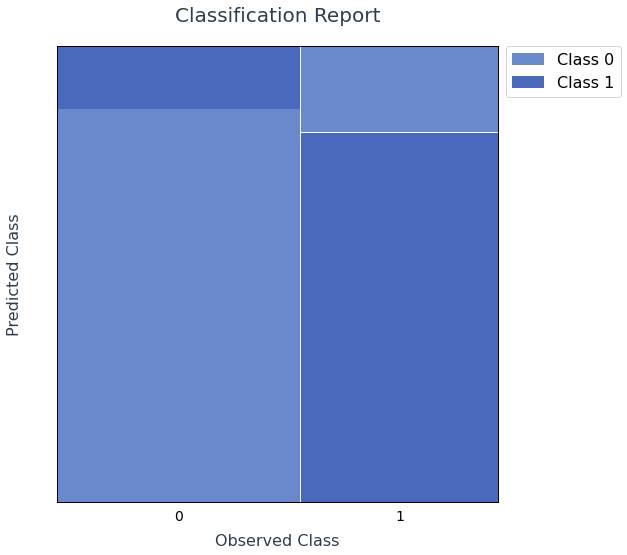

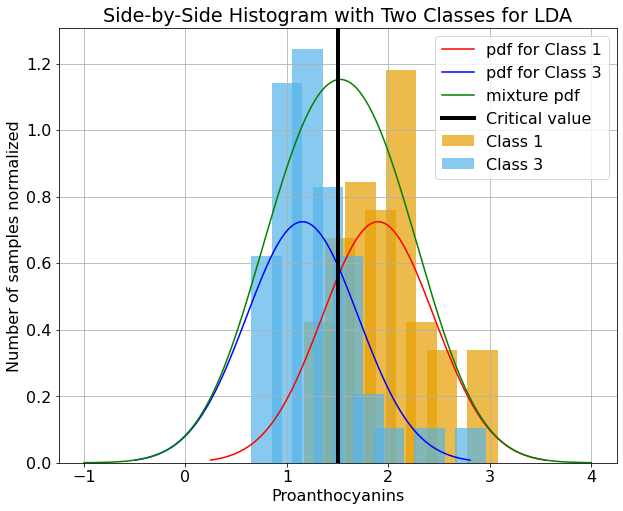



QDA
0-1 loss on train: 19 out of 107
type_I_error: 12
type_II_error: 7
LOOCV (sum): 19 out of 107
LOOCV (mean): 0.17757009345794392


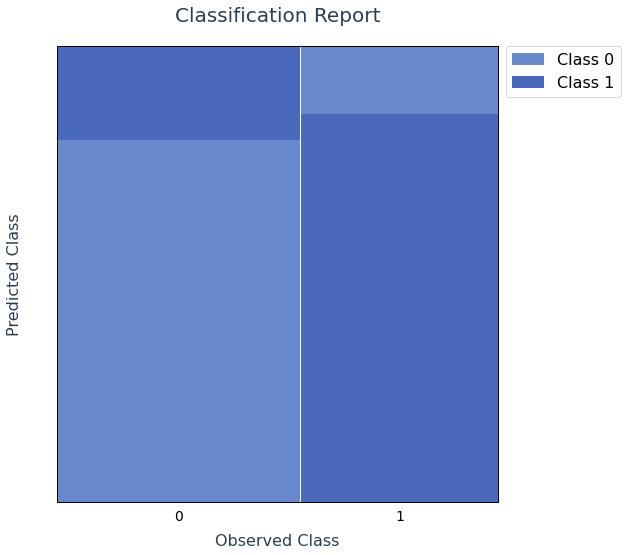

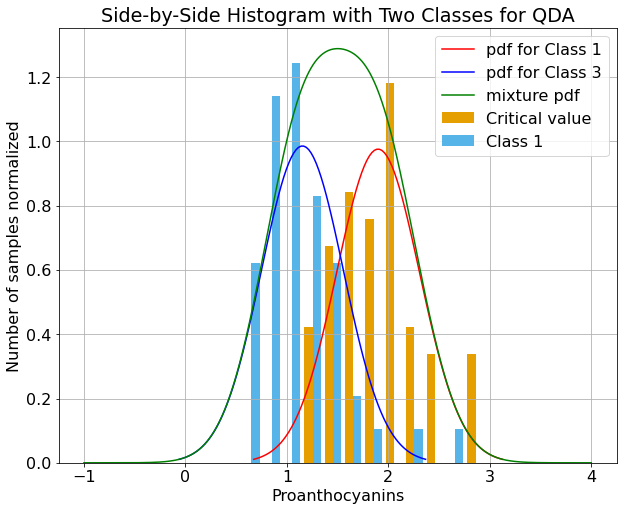



Gaussian Naive Bayes
0-1 loss on train: 19 out of 107
type_I_error: 12
type_II_error: 7
LOOCV (sum): 19 out of 107
LOOCV (mean): 0.17757009345794392


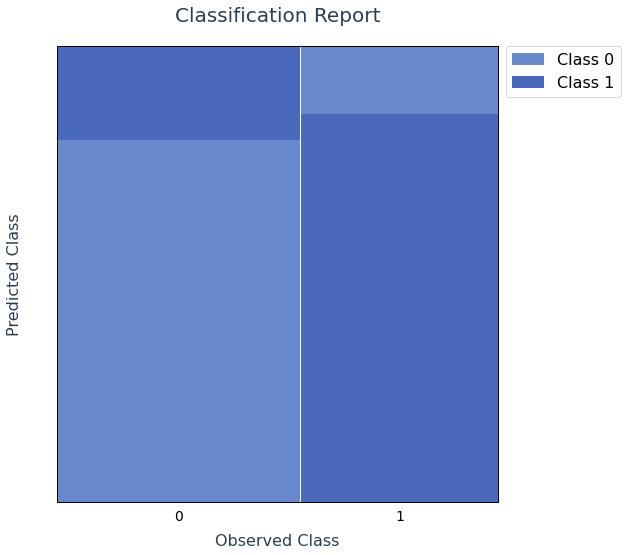

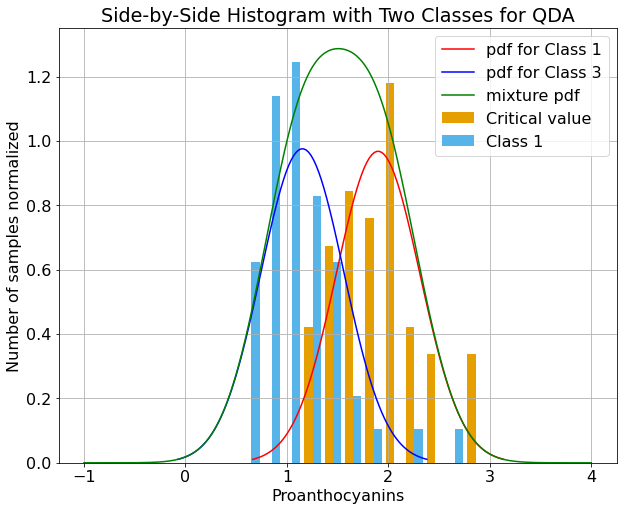

PART 2
LDA
0-1 loss on train: 8 out of 107
type_I_error: 3
type_II_error: 5
LOOCV (sum): 8 out of 107
LOOCV (mean): 0.07476635514018691


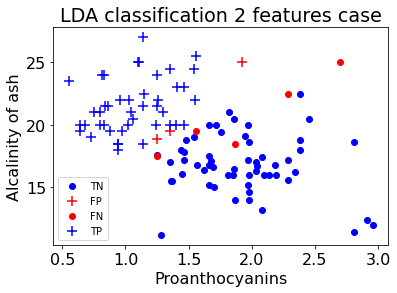

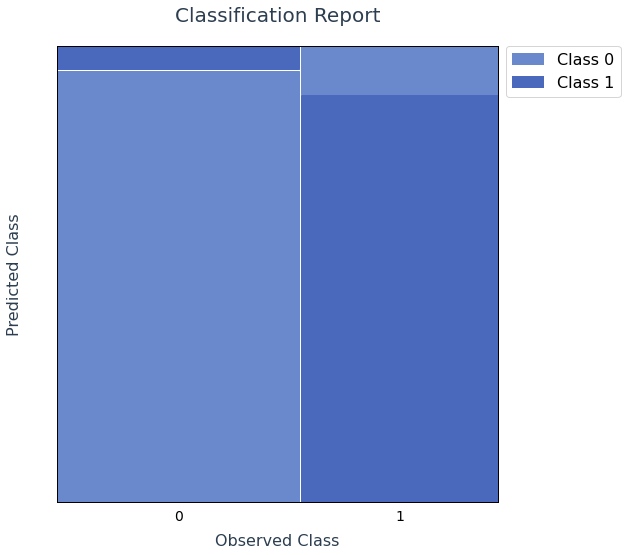

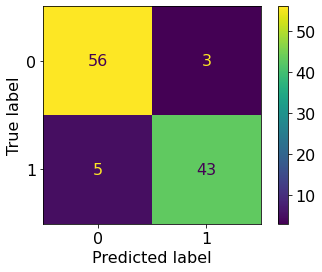

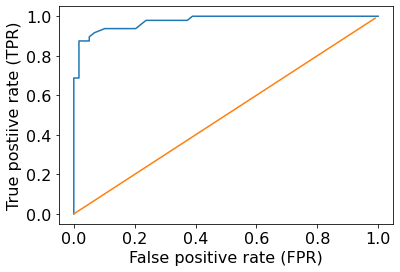

AUC = 0.975635593220339


QDA
0-1 loss on train: 7 out of 107
type_I_error: 3
type_II_error: 4
LOOCV (sum): 8 out of 107
LOOCV (mean): 0.07476635514018691


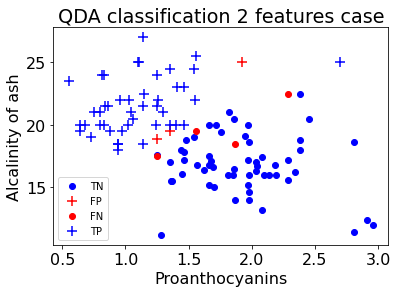

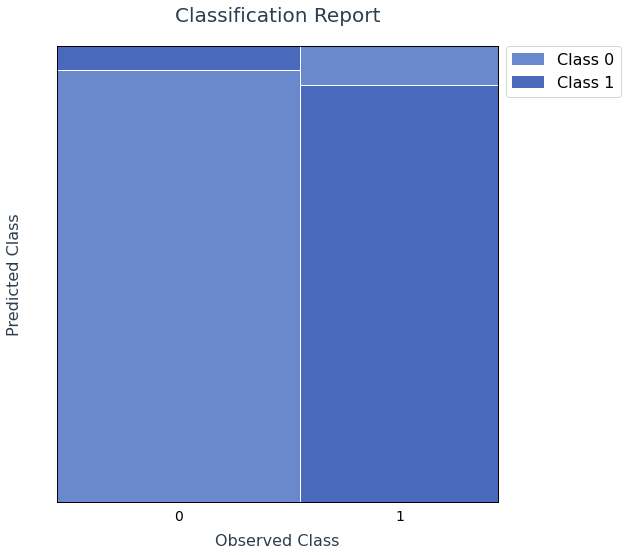

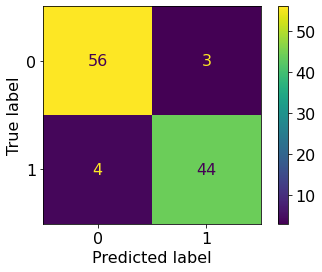

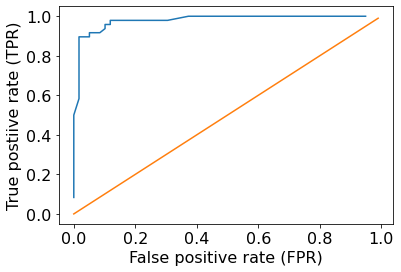

AUC = 0.9284957627118645


Gaussian Naive Bayes
0-1 loss on train: 7 out of 107
type_I_error: 3
type_II_error: 4
LOOCV (sum): 8 out of 107
LOOCV (mean): 0.07476635514018691


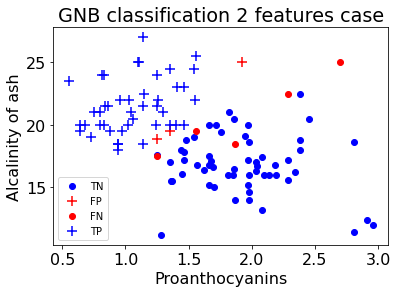

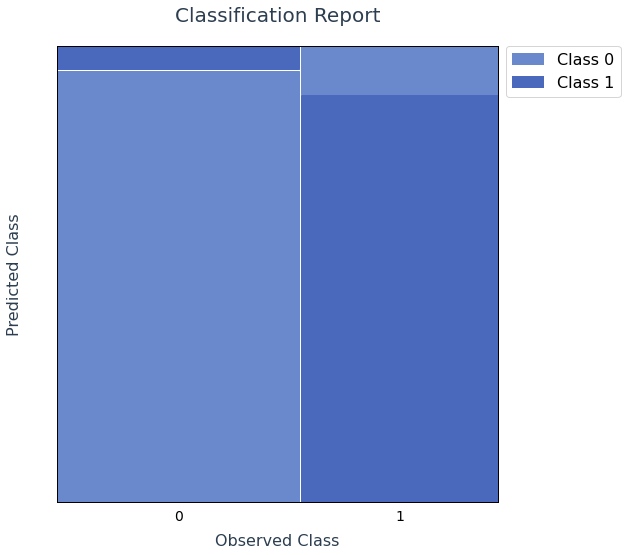

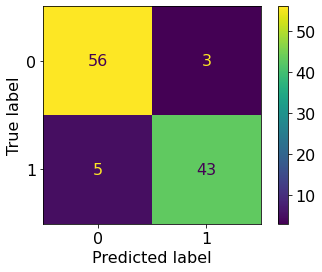

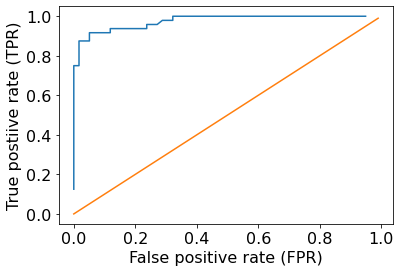

AUC = 0.9249646892655365
PART 3
QDA classifier for Alcohol

0-1 loss on train: 57 out of 178
LOOCV (sum): 58 out of 178
LOOCV (mean): 0.3258426966292135 


QDA classifier for Alcohol + Flavanoids

0-1 loss on train: 11 out of 178
LOOCV (sum): 12 out of 178
LOOCV (mean): 0.06741573033707865 


QDA classifier for Alcohol + Flavanoids + Proanthocyanins + Color intensity

0-1 loss on train: 6 out of 178
LOOCV (sum): 8 out of 178
LOOCV (mean): 0.0449438202247191 




In [43]:
main()